# Usefulness of IP edits

This covers the second question of [T231605](https://phabricator.wikimedia.org/T231605), aiming to answer the question of how useful edits by unregistered contributors are.

* How useful are IP edits on our projects?
  * Some ways to gauge this - how many of IP edits are reverted (good/bad faith)? How many of these IPs are eventually blocked?
  * What is the difference (if any) between IP behaviors on small vs large projects? Like, do IP editors cause more % of vandalism on smaller projects because they don't have as much capacity to deal with it?

## Canonical list of projects

I'm reusing Neil's code again for this.

In [1]:
import json
import re

import pandas as pd
import numpy as np
import requests
from wmfdata import mariadb, hive

import tabulate

You can find the source for `wmfdata` at https://github.com/neilpquinn/wmfdata


In [16]:
## Load the RPython library so we can use R for graphs

%load_ext rpy2.ipython

In [17]:
%%R
library(ggplot2)
library(data.table)


In [2]:
def get_dblist(list_name):
    list_url = ("https://noc.wikimedia.org/conf/dblists/" + list_name + ".dblist")
    list_content = requests.get(list_url).text.split("\n")
    return pd.Series(list_content)

In [3]:
wikis = mariadb.run("""
select
    site_global_key as database_code,
    concat(trim(leading "." from reverse(site_domain))) as domain_name,
    site_group as database_group,
    site_language as language_code
from enwiki.sites
""", "enwiki").sort_values("database_code").set_index("database_code")

wikis.head(10)

,domain_name,database_group,language_code
database_code,,,
aawiki,aa.wikipedia.org,wikipedia,aa
aawikibooks,aa.wikibooks.org,wikibooks,aa
aawiktionary,aa.wiktionary.org,wiktionary,aa
abwiki,ab.wikipedia.org,wikipedia,ab
abwiktionary,ab.wiktionary.org,wiktionary,ab
acewiki,ace.wikipedia.org,wikipedia,ace
advisorswiki,advisors.wikimedia.org,advisors,en
advisorywiki,advisory.wikimedia.org,advisory,en
adywiki,ady.wikipedia.org,wikipedia,ady


In [4]:
lang_urls = [
    "https://raw.githubusercontent.com/wikimedia/mediawiki-extensions-cldr/master/CldrNames/CldrNamesEn.php",
    "https://raw.githubusercontent.com/wikimedia/mediawiki-extensions-cldr/master/LocalNames/LocalNamesEn.php"
]

def get_lang_names(url):
    r = requests.get(url)
    m = re.search(r"languageNames = (\[[\s\S]+?\])", r.text)
    php_ln = m.group(1)
    
    json_ln = php_ln
    repl = [
        # Convert from PHP array format to JSON
        (" =>", ":"),
        ("\[", "{"),
        ("\]", "}"),
        # Trailing commas will cause problems
        (",\n}", "\n}"),
        # ...so will single quotes
        ("'", '"'),
        # ...and comments
        (r"/\*[\s\S]*?\*/", ""),
        (r"#(.*?)\n", ""),
        # One hack to deal with a single quote in a language name
        ('O"odham', "O'odham")
    ]
    for old, new in repl:
        json_ln = re.sub(old, new, json_ln)
    
    py_ln = json.loads(json_ln)
    return py_ln

langs = {}
for url in lang_urls:
    langs.update(get_lang_names(url))

# Add languages not included in the CLDR files
langs.update({
    "als": "Alsatian",
    "atj": "Atikamekw",
    "diq": "Zazaki",
    "fiu-vro": "Võro",
    "map-bms": "Banyumasan",
    "nah": "Nahuatl",
    "pih": "Norfuk-Pitkern",
    "rmy": "Vlax Romani",
    "simple": "Simple English"
})

wikis["language_name"] = wikis["language_code"].apply(langs.get)

wikis.head(10)

,domain_name,database_group,language_code,language_name
database_code,,,,
aawiki,aa.wikipedia.org,wikipedia,aa,Afar
aawikibooks,aa.wikibooks.org,wikibooks,aa,Afar
aawiktionary,aa.wiktionary.org,wiktionary,aa,Afar
abwiki,ab.wikipedia.org,wikipedia,ab,Abkhazian
abwiktionary,ab.wiktionary.org,wiktionary,ab,Abkhazian
acewiki,ace.wikipedia.org,wikipedia,ace,Achinese
advisorswiki,advisors.wikimedia.org,advisors,en,English
advisorywiki,advisory.wikimedia.org,advisory,en,English
adywiki,ady.wikipedia.org,wikipedia,ady,Adyghe


In [5]:
closed = get_dblist("closed")
private = get_dblist("private")

def apply_to_index(df, true_list, true_label, false_label):
    idx_ser = df.index.to_series()
    return idx_ser.isin(true_list).apply(lambda x: true_label if x else false_label)

wikis = (
    wikis
    .assign(
        status=lambda df: apply_to_index(df, closed, "closed", "open"),
        visbility=lambda df: apply_to_index(df, private, "private", "public")
    )
)

wikis.head(10)

,domain_name,database_group,language_code,language_name,status,visbility
database_code,,,,,,
aawiki,aa.wikipedia.org,wikipedia,aa,Afar,closed,public
aawikibooks,aa.wikibooks.org,wikibooks,aa,Afar,closed,public
aawiktionary,aa.wiktionary.org,wiktionary,aa,Afar,closed,public
abwiki,ab.wikipedia.org,wikipedia,ab,Abkhazian,open,public
abwiktionary,ab.wiktionary.org,wiktionary,ab,Abkhazian,closed,public
acewiki,ace.wikipedia.org,wikipedia,ace,Achinese,open,public
advisorswiki,advisors.wikimedia.org,advisors,en,English,open,private
advisorywiki,advisory.wikimedia.org,advisory,en,English,closed,public
adywiki,ady.wikipedia.org,wikipedia,ady,Adyghe,open,public


What are the projects we're interested in? I propose the following, although I can see the Outreach wiki also being one of them.

In [146]:
projects = ['commons', 'mediawiki', 'meta', 'wikibooks', 'wikidata', 'wikinews', 'wikipedia',
            'wikiquote', 'wikisource', 'wikiversity', 'wikivoyage', 'wiktionary']

## Determining time to block

Let's grab data from three wikis, one larger, one medium sized, and one smaller. Then, we'll calculate time between an edit and the subsequent block, and make a plot of the distributions.

I'll use the [List of Wikipedias](https://meta.wikimedia.org/wiki/List_of_Wikipedias) to select these, partly because I'm more familiar with the Wikipedia family of projects. For a larger wiki, I'll look at the ones with more than 1 million articles. Here, I think the Japanese Wikipedia is a good candidate, because our analysis of overall IP proportion found it to be large (27.2%). Spanish Wikipedia is also a good candidate as well, by the way. Both have hundreds of thousands of edits per month.

For a medium sized wiki, I choose the Greek Wikipedia. It's got 168,000 articles, a good number of edits on a monthly average (tens of thousands), and about 20% of them are IP edits.

For a smaller wiki, I choose two, the Somali and Swahili Wikipedias. The Somali Wikipedia has few articles (6,126) a fair number of monthly edits (1,250), and a high IP proportion (40.6). Swahili Wikipedia has a higher number of articles (53,838), higher number of monthly edits (almost 3,500), but a much lower IP proportion (3.3%).

In [48]:
## Query to get data on IP edits to our candidate wikis from Sept 2018 through August 2019,
## where the IP was subsequently blocked within 7 days after editing, and with time to
## block calculated.

## NOTE: I'll use August to August as the time basis here, because otherwise the 7-day
## limitation doesn't work (we don't have data into September 2019).

## NOTE: this query has been updated to include mainly larger wikis due to data shortage.

time_to_block_query = '''
WITH edits AS (
    SELECT wiki_db, event_timestamp, event_user_text
    FROM wmf.mediawiki_history
    WHERE snapshot = "2019-08"
    AND wiki_db IN ("jawiki", "elwiki", "enwiki", "frwiki", "dewiki", 
                    "nlwiki", "ptwiki", "itwiki", "eswiki", "zhwiki")
    AND event_timestamp > "2018-08-01"
    AND event_timestamp < "2019-08-01"
    AND event_entity = "revision"
    AND event_type = "create"
    AND array_contains(revision_deleted_parts, 'user') = false -- skip revisions w/deleted user info
    AND event_user_is_anonymous = true
    AND revision_is_identity_reverted = true
    AND revision_seconds_to_identity_revert < 60*60*48
),
blocks AS (
    SELECT wiki_db, ipb_timestamp, ipb_address
    FROM wmf_raw.mediawiki_ipblocks
    WHERE snapshot = "2019-08"
    AND wiki_db IN ("jawiki", "elwiki", "enwiki", "frwiki", "dewiki", 
                    "nlwiki", "ptwiki", "itwiki", "eswiki", "zhwiki")
    AND ipb_timestamp > "20180801"
    AND ipb_timestamp < "20190808" -- 7 days after last edit
    AND ipb_user = 0 -- only IP blocks
    AND ipb_auto = 0 -- no auto-blocks (IP blocked because a blocked user used it)
)
SELECT edits.wiki_db, event_user_text,
unix_timestamp(blocks.ipb_timestamp, "YYYYMMddhhmmss") -
unix_timestamp(edits.event_timestamp, "yyyy-MM-dd hh:mm:ss.0") AS time_to_block
FROM edits
JOIN blocks
ON (edits.wiki_db = blocks.wiki_db
    AND edits.event_user_text = blocks.ipb_address)
WHERE 
unix_timestamp(blocks.ipb_timestamp, "YYYYMMddhhmmss") -
unix_timestamp(edits.event_timestamp, "yyyy-MM-dd hh:mm:ss.0") BETWEEN 1 AND 60*60*24*7
'''

I'm not getting the amount of data that I expected, so I need to check my assumptions.

First assumption: how many IP reverts are there within 48 hours in my dataset? There should be lots.

In [34]:
num_revert_query = '''
SELECT wiki_db, count(*) AS num_reverted_ip_edits
    FROM wmf.mediawiki_history
    WHERE snapshot = "2019-08"
    AND wiki_db IN ("jawiki", "elwiki", "sowiki", "swwiki")
    AND event_timestamp > "2014-08-01"
    AND event_timestamp < "2019-08-01"
    AND event_entity = "revision"
    AND event_type = "create"
    AND array_contains(revision_deleted_parts, 'user') = false -- skip revisions w/deleted user info
    AND event_user_is_anonymous = true
    AND revision_is_identity_reverted = true
    AND revision_seconds_to_identity_revert < 60*60*48
GROUP BY wiki_db
LIMIT 20
'''

In [31]:
hive.run(num_revert_query)

,wiki_db,_c1
0,jawiki,410158
1,sowiki,663
2,elwiki,121252
3,swwiki,1134


There's only lots on the larger wikis.

Second assumption. How many IP blocks are in my dataset? There should also be lots.

In [49]:
num_blocks_query = '''
SELECT wiki_db, count(*) AS num_blocks
    FROM wmf_raw.mediawiki_ipblocks
    WHERE snapshot = "2019-08"
    AND wiki_db IN ("jawiki", "elwiki", "sowiki", "swwiki")
    AND ipb_timestamp > "20140801"
    AND ipb_timestamp < "20190801"
    AND ipb_user = 0 -- only IP blocks
    AND ipb_auto = 0 -- no auto-blocks (IP blocked because a blocked user used it)
GROUP BY wiki_db
LIMIT 20
'''

In [50]:
hive.run(num_blocks_query)

,wiki_db,num_blocks
0,elwiki,14
1,jawiki,3092
2,sowiki,4
3,swwiki,32


Based on this information, it seems clear that to get any meaningful data on this, we'll have to look at some of the big wikis, because otherwise this doesn't happen often enough. It might also mean that unless we're looking at range blocks, we're not capturing the right information.

What's the use of range blocks vs specific IPs on for example English Wikipedia over the last year?

In [73]:
range_query = '''
SELECT
  SUM(IF(ipb_range_start = ipb_range_end, 1, 0)) AS num_singles,
  SUM(IF(ipb_range_start != ipb_range_end, 1, 0)) AS num_ranges
FROM wmf_raw.mediawiki_ipblocks
WHERE snapshot = "2019-08"
AND wiki_db = "enwiki"
AND ipb_timestamp >= "20180801"
AND ipb_timestamp < "20190801"
AND ipb_user = 0 -- only IP blocks
AND ipb_auto = 0 -- no auto-blocks (IP blocked because a blocked user used it)
'''

In [74]:
hive.run(range_query)

,num_singles,num_ranges
0,55672,10555


So the ratio of single to range blocks for English Wikipedia is about 5:1. English Wikipedia has on average 788,355 anonymous edits per month across the same time period, or about 9.3 million in total. 66,000 blocks versus 9.3 million IP edits, that's not a lot of blocks (NOTE: that conclusion is incorrect, the `ipblocks` table holds the current state of blocks and does not reflect blocking history, that's instead in the `logging` table, which is why the subsequent queries use that table).

Another assumption I have to revisit in my query above is that I allow for 48 hours until an edit is reverted, and up to 7 days for the subsequent block. But, I'm not enforcing that the block has to happen after the edit got reverted. I can use `revision_first_identity_reverting_revision_id` to get that revision, then require the block to occur after it. But, the question is whether the block happens before or after that revert. I suspect before, but perhaps not by much.

In [115]:
## Query to estimate "time to block" for reverted IP edits where the user was subsequently blocked.

time_to_block_query = '''
WITH edits AS (
    SELECT wiki_db, unix_timestamp(event_timestamp, "yyyy-MM-dd hh:mm:ss.0") AS event_time,
    event_user_text, revision_id, revision_first_identity_reverting_revision_id
    FROM wmf.mediawiki_history
    WHERE snapshot = "2019-08"
    AND wiki_db IN ("jawiki", "elwiki", "sowiki", "swwiki", "enwiki", "frwiki", "dewiki", "eswiki")
    AND event_timestamp >= "2018-08-01"
    AND event_timestamp < "2019-08-01"
    AND event_entity = "revision"
    AND event_type = "create"
    AND array_contains(revision_deleted_parts, 'user') = false -- skip revisions w/deleted user info
    AND event_user_is_anonymous = true
    AND ((revision_is_identity_reverted = true
          AND revision_seconds_to_identity_revert < 60*60*48)
         OR array_contains(revision_deleted_parts, 'text') = true) -- revision content was deleted
),
reverts AS (
    SELECT wiki_db, unix_timestamp(event_timestamp, "yyyy-MM-dd hh:mm:ss.0") AS event_time, revision_id
    FROM wmf.mediawiki_history
    WHERE snapshot = "2019-08"
    AND wiki_db IN ("jawiki", "elwiki", "sowiki", "swwiki", "enwiki", "frwiki", "dewiki", "eswiki")
    AND event_timestamp >= "2018-08-01"
    AND event_timestamp < "2019-08-03" -- allow for 48 hours before the revert
    AND event_entity = "revision"
    AND event_type = "create"
    AND revision_is_identity_revert = true
),
blocks AS (
    SELECT wiki_db, unix_timestamp(log_timestamp, "yyyyMMddhhmmss") AS log_time, log_title
    FROM wmf_raw.mediawiki_logging
    WHERE snapshot = "2019-08"
    AND wiki_db IN ("jawiki", "elwiki", "sowiki", "swwiki", "enwiki", "frwiki", "dewiki", "eswiki")
    AND log_timestamp >= "20180801000000"
    AND log_timestamp < "20190808000000" -- 7 days after last edit
    AND log_type = "block"
    AND log_action = "block"
)
SELECT edits.wiki_db, event_user_text, edits.revision_id,
from_unixtime(edits.event_time) AS event_timestamp,
from_unixtime(reverts.event_time) AS revert_timestamp,
from_unixtime(log_time) AS block_timestamp,
log_time - reverts.event_time AS revert_time_to_block,
log_time - edits.event_time AS edit_time_to_block
FROM edits
JOIN reverts
ON (edits.wiki_db = reverts.wiki_db
    AND edits.revision_first_identity_reverting_revision_id = reverts.revision_id)
CROSS JOIN blocks
ON (edits.wiki_db = blocks.wiki_db
    AND edits.event_user_text = blocks.log_title)
WHERE edits.event_time < blocks.log_time -- block has to come after edit
    AND blocks.log_time - edits.event_time < 60*60*24*7 -- less than a week to block
'''

In [116]:
time_to_block_data = hive.run(time_to_block_query)

In [117]:
len(time_to_block_data)

629015

In [ ]:
time_to_block_data.loc[(time_to_block_data.revert_time_to_block < 60*60*24) |
                       (time_to_block_data.edit_time_to_block < 60*60*24)].head(50)

After looking at the block data, it seems clear that an IP gets blocked because they've made *multiple* edits that get reverted. So, they show up multiple times in the dataset. That also means that the data is skewed towards those. Doesn't seem like a user making a single edit is going to get them reverted.

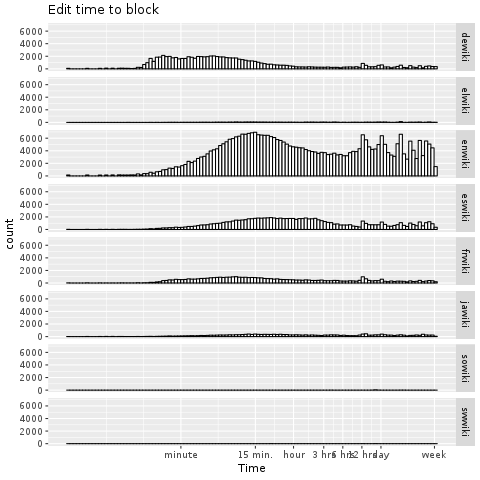

In [125]:
%%R -i time_to_block_data

time_to_block_data = data.table(time_to_block_data)

g = ggplot(time_to_block_data,
       aes(x = edit_time_to_block)) + 
  geom_histogram(binwidth = 0.05, colour="black", fill='white') +
    ggtitle("Edit time to block") +
  scale_x_log10(
    "Time",
    breaks=c(60, 15*60, 60*60, 3*3600, 6*3600, 12*3600, 24*60*60, 7*24*60*60, 30*24*60*60, 365*24*60*60),
    labels=c("minute", "15 min.", "hour", "3 hrs", "6 hrs", "12 hrs", "day", "week", "month", "year")) +
  facet_grid(wiki_db ~ .)

ggsave("graphs/edit_time_to_block.png",
       plot = g, width = 8, height = 6, units = "in", dpi = "retina")
g

This looks more sane.

In [124]:
len(time_to_block_data.loc[time_to_block_data.wiki_db == 'enwiki'])

378294

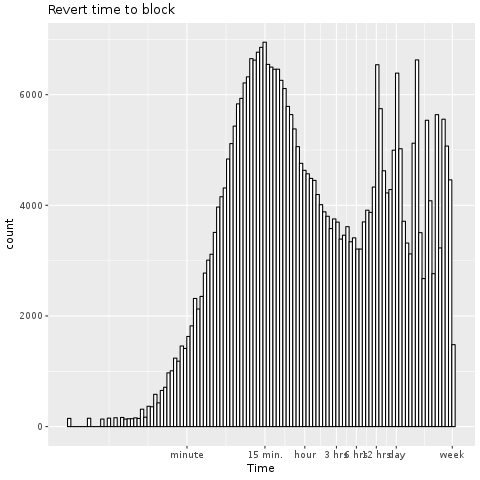

In [123]:
%%R -i time_to_block_data

time_to_block_data = data.table(time_to_block_data)

g = ggplot(time_to_block_data[wiki_db == "enwiki"],
       aes(x = edit_time_to_block)) + 
  geom_histogram(binwidth = 0.05, colour="black", fill='white') +
    ggtitle("Edit time to block") +
  scale_x_log10(
    "Time",
    breaks=c(60, 15*60, 60*60, 3*3600, 6*3600, 12*3600, 24*60*60, 7*24*60*60, 30*24*60*60, 365*24*60*60),
    labels=c("minute", "15 min.", "hour", "3 hrs", "6 hrs", "12 hrs", "day", "week", "month", "year"))

ggsave("graphs/enwiki_edit_time_to_block.png",
       plot = g, width = 8, height = 6, units = "in", dpi = "retina")
g

Examining these plots, we can see some trends and distinctions. There's consistently a bump at 12 hours. That might be because the buckets get wider towards the right (due to the log scale X-axis), but given the difference between the previous bucket and the 12 hours one, there seems to clearly be an increase happening around the 12-hour mark. Looking more closely at the English Wikiedia graph, we see that the increase starts before the 12-hour mark, the minimum is instead around 6 hours, but there is a definite jump at 12 hours.

From the plot showing multiple wikis, we can also see differences in time between them. German and French Wikipedia appear to react very quickly. Spanish Wikipedia is different, there the spread looks wider. Where dewiki and frwiki looks to be focused on the seconds/minute to one hour, eswiki looks like 15 mins to 3 hours or so.

First, let's go back to the original four wikis to get a sense of how things work there.

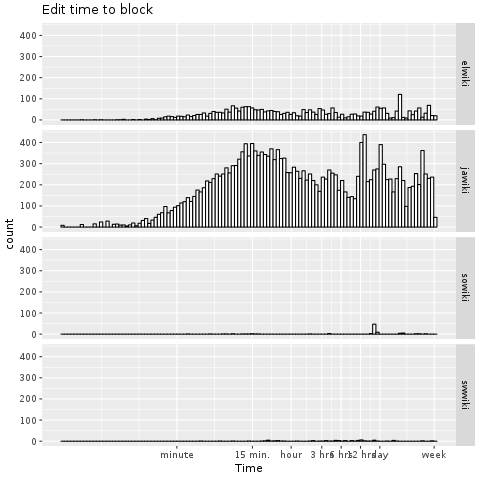

In [126]:
%%R -i time_to_block_data

time_to_block_data = data.table(time_to_block_data)

g = ggplot(time_to_block_data[wiki_db %in% c('jawiki', 'elwiki', 'sowiki', 'swwiki')],
       aes(x = edit_time_to_block)) + 
  geom_histogram(binwidth = 0.05, colour="black", fill='white') +
    ggtitle("Edit time to block") +
  scale_x_log10(
    "Time",
    breaks=c(60, 15*60, 60*60, 3*3600, 6*3600, 12*3600, 24*60*60, 7*24*60*60, 30*24*60*60, 365*24*60*60),
    labels=c("minute", "15 min.", "hour", "3 hrs", "6 hrs", "12 hrs", "day", "week", "month", "year")) +
  facet_grid(wiki_db ~ .)

#ggsave("graphs/edit_time_to_block.png",
#       plot = g, width = 8, height = 6, units = "in", dpi = "retina")
g

I was mainly interested in examining the original four to see whether to set a threshold at 3 hours or 6 hours. Based on the Japanese and Greek plots, I think setting it at 6 hours makes sense.

So, similarly as before, we want a query that for each month in our 12-month window gives us the total number of edits, number of IP edits, number of IP edits that were reverted (within 48 hours), number of IP edits that had the content deleted (at some point, we don't know when), number of edits that were either reverted that were subsequently blocked within 6 hours, number of edits with content revdeleted that were blocked within 6 hours.

Note that being reverted and having the content revdeleted are mutually exclusive, so we can add them together later. We should also note that an IP can make multiple edits and then be blocked, so prolific ones will be featured more often in the dataset.

Because it's easier to write two queries instead of one that gets everything, I'll first reuse the query from the initial analysis to get the number of IP edits per month, then join that with data from another query that gets the number of IP edits that were reverted, revdeleted, and blocked.

Note that the task asks for this data on IP edits, and not for registered accounts, so we're not doing a comparative analysis.

In [141]:
## Query to count IP edits overall.

overall_ip_edits_query = '''
SELECT wiki_db, DATE_FORMAT(event_timestamp, "yyyy-MM-01") AS log_month,
    COUNT(*) AS num_edits,
    SUM(IF(revision_is_identity_reverted = true
            AND revision_seconds_to_identity_revert < 60*60*48, 1, 0)) AS num_reverted,
    SUM(IF(array_contains(revision_deleted_parts, 'text') = true, 1, 0)) AS num_deleted
FROM wmf.mediawiki_history
WHERE snapshot = "{snapshot}"
AND event_entity = "revision"
AND event_type = "create"
AND array_contains(revision_deleted_parts, 'user') = false -- skip revisions w/deleted user info
AND event_timestamp >= "{start_date}"
AND event_timestamp < "{end_date}"
AND wiki_db IN ({wiki_list})
AND event_user_is_anonymous = true
GROUP BY wiki_db, DATE_FORMAT(event_timestamp, "yyyy-MM-01")
LIMIT 50000
'''

In [135]:
## Query to count stats for IP edits that were reverted and/or revdeleted
## and subsequently blocked or not.

revert_block_query = '''
WITH edits AS (
    SELECT wiki_db, DATE_FORMAT(event_timestamp, "yyyy-MM-01") AS log_month,
    unix_timestamp(event_timestamp, "yyyy-MM-dd hh:mm:ss.0") AS event_time, event_user_text,
    revision_is_identity_reverted, revision_seconds_to_identity_revert, revision_deleted_parts
    FROM wmf.mediawiki_history
    WHERE snapshot = "{snapshot}"
    AND wiki_db IN ({wiki_list})
    AND event_timestamp >= "{start_date}"
    AND event_timestamp < "{end_date}"
    AND event_entity = "revision"
    AND event_type = "create"
    AND array_contains(revision_deleted_parts, 'user') = false -- skip revisions w/deleted user info
    AND event_user_is_anonymous = true
    AND ((revision_is_identity_reverted = true
          AND revision_seconds_to_identity_revert < 60*60*48)
         OR array_contains(revision_deleted_parts, 'text') = true) -- revision content was deleted
),
blocks AS (
    SELECT wiki_db, unix_timestamp(log_timestamp, "yyyyMMddhhmmss") AS log_time, log_title
    FROM wmf_raw.mediawiki_logging
    WHERE snapshot = "{snapshot}"
    AND wiki_db IN ({wiki_list})
    AND log_timestamp >= "{start_ts}"
    AND log_timestamp < "{end_ts}" -- 6 hours after last edit
    AND log_type = "block"
    AND log_action = "block"
)
SELECT edits.wiki_db, from_unixtime(event_time, "yyyy-MM-01") AS log_month,
    SUM(IF(revision_is_identity_reverted
           AND revision_seconds_to_identity_revert < 3600*48, 1, 0)) AS num_reverted_blocked,
    SUM(IF(array_contains(revision_deleted_parts, 'text') = true, 1, 0)) AS num_deleted_blocked
FROM edits
CROSS JOIN blocks
ON (edits.wiki_db = blocks.wiki_db
    AND edits.event_user_text = blocks.log_title)
WHERE edits.event_time < blocks.log_time -- block has to come after edit
      AND blocks.log_time - edits.event_time < 3600*6 -- less than 6 hours to block
GROUP BY edits.wiki_db, from_unixtime(event_time, "yyyy-MM-01")
LIMIT 50000
'''

Let's run both queries to get the data that we need, then join them.

In [142]:
## NOTE: we limit the data gathering of edit counts to only open and public wikis here.
overall_ip_edits = hive.run(
    overall_ip_edits_query.format(
        snapshot = '2019-08',
        start_date = '2018-09-01',
        end_date = '2019-09-01',
        wiki_list = ', '.join(
            ['"{}"'.format(w) for w in wikis.loc[(wikis.status == 'open') &
                                                 (wikis.visbility == 'public')].index.tolist()])
    )
)

In [ ]:
## NOTE: we limit the data gathering of edit counts to only open and public wikis here.

blocked_ip_edits = hive.run(
    revert_block_query.format(
        snapshot = '2019-08',
        start_date = '2018-09-01',
        end_date = '2019-09-01',
        start_ts = '20180901000000',
        end_ts = '20190901060000',
        wiki_list = ', '.join(
            ['"{}"'.format(w) for w in wikis.loc[(wikis.status == 'open') &
                                                 (wikis.visbility == 'public')].index.tolist()])
    )
)

In [ ]:
blocked_ip_edits.head()

Okay, it looks like I've got the data that I need. Merge them on wiki and month.

In [143]:
blocked_data = overall_ip_edits.merge(blocked_ip_edits, how = 'left',
                                     on = ['wiki_db', 'log_month']).fillna(0)

In [147]:
blocked_data.head()

,wiki_db,log_month,num_edits,num_reverted,num_deleted,num_reverted_blocked,num_deleted_blocked
0,bgwikibooks,2018-10-01,4,0,0,0.0,0.0
1,chrwiki,2019-07-01,6,4,0,0.0,0.0
2,eowikibooks,2019-06-01,5,0,0,0.0,0.0
3,eswiktionary,2018-10-01,3922,539,104,17.0,15.0
4,liwiktionary,2018-11-01,2,1,0,0.0,0.0


## Yearly stats

Over the past year, how many IP edits did we have on each project, and to what extent were those edits reverted or revdeleted, and did the reverts/revdeletions result in blocks?

In [ ]:
wikis.head()

In [174]:
yearly_stats = (blocked_data.set_index('wiki_db')
                .merge(wikis[['database_group']], left_index = True, right_index = True)
                .reset_index().groupby('database_group').sum())

Note: it might be confusing to see all the wikimedia projects in the yearly stats. Those are the local chapter wikis. Would perhaps be useful if they had their own database group designation (e.g. wikimedia, but that might be reserved for the WMF).

In [176]:
yearly_stats.head()

,num_edits,num_reverted,num_deleted,num_reverted_blocked,num_deleted_blocked
database_group,,,,,
arwikimedia,18,0,0,0.0,0.0
bdwikimedia,18,6,0,3.0,0.0
betawikiversity,13932,538,0,23.0,0.0
bewikimedia,13,1,0,0.0,0.0
brwikimedia,15,0,0,0.0,0.0


In [178]:
yearly_stats['prop_reverted'] = 100 * yearly_stats['num_reverted'] / yearly_stats['num_edits']
yearly_stats['prop_revdeleted'] = 100 * yearly_stats['num_deleted'] / yearly_stats['num_edits']
yearly_stats['prop_reverted_blocked'] = 100 * yearly_stats['num_reverted_blocked'] / yearly_stats['num_edits']
yearly_stats['prop_revdeleted_blocked'] = 100 * yearly_stats['num_deleted_blocked'] / yearly_stats['num_edits']

What are the projects we're interested in? I propose the following, although I can see the Outreach wiki also being one of them.

In [ ]:
projects = ['commons', 'mediawiki', 'meta', 'wikibooks', 'wikidata', 'wikinews', 'wikipedia',
            'wikiquote', 'wikisource', 'wikiversity', 'wikivoyage', 'wiktionary']

In [ ]:
print(
    tabulate.tabulate(
        yearly_stats.loc[projects]
        [['num_edits', 'num_reverted', 'prop_reverted', 'num_deleted', 'prop_revdeleted',
          'num_reverted_blocked', 'prop_reverted_blocked', 'num_deleted_blocked', 'prop_revdeleted_blocked']]
        .rename(
            columns = {'num_edits' : 'N IP edits',
                       'num_reverted' : 'N reverted',
                       'prop_reverted' : '% reverted',
                       'num_deleted' : 'N revdeleted',
                       'prop_revdeleted' : '% revdeleted',
                       'num_reverted_blocked' : 'N reverted blocked',
                       'prop_reverted_blocked' : '% reverted blocked',
                       'num_deleted_blocked' : 'N revdeleted blocked',
                       'prop_revdeleted_blocked' : '% revdeleted blocked'}
        ), headers = 'keys', tablefmt = 'github',
        floatfmt=["f", ".0f", ".0f", ".1f", ".0f", ".1f", ".0f", ".1f", ".0f", ".1f", ".0f", ".1f"]
    )
)

In [ ]:
print(
    tabulate.tabulate(
        yearly_stats.loc[projects]
        [['num_edits', 'num_reverted', 'prop_reverted', 'num_deleted', 'prop_revdeleted',
          'num_reverted_blocked', 'prop_reverted_blocked', 'num_deleted_blocked', 'prop_revdeleted_blocked']]
        .rename(
            columns = {'num_edits' : 'N IP edits',
                       'num_reverted' : 'N reverted',
                       'prop_reverted' : '% reverted',
                       'num_deleted' : 'N revdeleted',
                       'prop_revdeleted' : '% revdeleted',
                       'num_reverted_blocked' : 'N reverted blocked',
                       'prop_reverted_blocked' : '% reverted blocked',
                       'num_deleted_blocked' : 'N revdeleted blocked',
                       'prop_revdeleted_blocked' : '% revdeleted blocked'}
        ), headers = 'keys', tablefmt = 'mediawiki',
        floatfmt=["f", ".0f", ".0f", ".1f", ".0f", ".1f", ".0f", ".1f", ".0f", ".1f", ".0f", ".1f"]
    )
)

## Per-project statistics

For each of the overarching projects, we want to split it out by language, calculate monthly averages and provide min/max values as well.

In [148]:
per_project_stats = (blocked_data.set_index('wiki_db')
                     .merge(wikis[['database_group', 'language_name']],
                            left_index = True, right_index = True)
                     .reset_index().rename(columns = {'index': 'wiki_db'}))
per_project_stats = per_project_stats.loc[per_project_stats.database_group.isin(projects)]

In [150]:
per_project_stats.head()

,wiki_db,log_month,num_edits,num_reverted,num_deleted,num_reverted_blocked,num_deleted_blocked,database_group,language_name
0,abwiki,2018-10-01,22,0,0,0.0,0.0,wikipedia,Abkhazian
1,abwiki,2018-12-01,4,0,0,0.0,0.0,wikipedia,Abkhazian
2,abwiki,2019-02-01,4,0,0,0.0,0.0,wikipedia,Abkhazian
3,abwiki,2019-04-01,89,17,0,0.0,0.0,wikipedia,Abkhazian
4,abwiki,2019-06-01,196,22,0,5.0,0.0,wikipedia,Abkhazian


In [165]:
def monthly_overview(group):
    aggs = {
        'mean_ip_edits' : group['num_edits'].mean(),
        'mean_reverted' : group['num_reverted'].mean(),
        'mean_revdeleted' : group['num_deleted'].mean(),
        'mean_reverted_blocked' : group['num_reverted_blocked'].mean(),
        'mean_revdeleted_blocked' : group['num_deleted_blocked'].mean(),
        'mean_prop_reverted' : 100 * group['num_reverted'].mean() / group['num_edits'].mean(),
        'min_prop_reverted' : 100 * np.min(group['num_reverted'] / group['num_edits']),
        'max_prop_reverted' : 100 * np.max(group['num_reverted'] / group['num_edits']),
        'mean_prop_revdeleted' : 100 * group['num_deleted'].mean() / group['num_edits'].mean(),
        'min_prop_revdeleted' : 100 * np.min(group['num_deleted'] / group['num_edits']),
        'max_prop_revdeleted' : 100 * np.max(group['num_deleted'] / group['num_edits']),
        'mean_prop_reverted_blocked' : 100 * group['num_reverted_blocked'].mean() / group['num_edits'].mean(),
        'min_prop_reverted_blocked' : 100 * np.min(group['num_reverted_blocked'] / group['num_edits']),
        'max_prop_reverted_blocked' : 100 * np.max(group['num_reverted_blocked'] / group['num_edits']),
        'mean_prop_revdeleted_blocked' : 100 * group['num_deleted_blocked'].mean() / group['num_edits'].mean(),
        'min_prop_revdeleted_blocked' : 100 * np.min(group['num_deleted_blocked'] / group['num_edits']),
        'max_prop_revdeleted_blocked' : 100 * np.max(group['num_deleted_blocked'] / group['num_edits']),
                                                                                                               
    }
    return(pd.Series(aggs, index = aggs.keys()))

In [166]:
per_project_stats_agg = per_project_stats.groupby(['database_group', 'language_name']).apply(monthly_overview)

In [167]:
per_project_stats_agg = per_project_stats_agg.reset_index().set_index('database_group')

In [168]:
per_project_stats_agg.query('database_group == "wikipedia" and language_name == "English"')

,language_name,mean_reverted_blocked,min_prop_reverted,mean_prop_revdeleted_blocked,max_prop_reverted,mean_prop_reverted,mean_revdeleted_blocked,mean_prop_revdeleted,max_prop_revdeleted_blocked,mean_prop_reverted_blocked,mean_revdeleted,mean_ip_edits,min_prop_revdeleted_blocked,mean_reverted,max_prop_revdeleted,min_prop_reverted_blocked,max_prop_reverted_blocked,min_prop_revdeleted
database_group,,,,,,,,,,,,,,,,,,
wikipedia,English,20953.25,24.181631,0.227055,29.227604,27.379485,1790.0,0.465769,0.793461,2.657844,3671.916667,788355.166667,0.071681,215847.583333,1.083924,1.918489,3.188425,0.272322


Note: It might be possible to get numbers formatted properly in MediaWiki by converting from a number to a string (so it's `"{{formatnum:\d+}}"`) and then perhaps use `stralign` in `tabulate.tabulate` to right-align the relevant columns. Will have to try that for a later iteration.

In [187]:
def print_project_group(df, group_name, table_format = 'mediawiki', precision = 1):
    '''
    From the aggregated project statistics, print out a table of the monthly average statistics
    using the given table format (default is a wikitable). Expects the DataFrame `df` to have
    an index so that `group_name` matches.
    '''
    
    column_order = ['language_name', 'mean_ip_edits',
                    'mean_reverted', 'mean_prop_reverted', 'min_prop_reverted', 'max_prop_reverted',
                    'mean_revdeleted', 'mean_prop_revdeleted', 'min_prop_revdeleted', 'max_prop_revdeleted',
                    'mean_reverted_blocked', 'mean_prop_reverted_blocked', 'min_prop_reverted_blocked', 'max_prop_reverted_blocked',
                    'mean_revdeleted_blocked', 'mean_prop_revdeleted_blocked', 'min_prop_revdeleted_blocked', 'max_prop_revdeleted_blocked']
    
    column_renaming = {
        'language_name' : 'Language',
        'mean_ip_edits' : 'Monthly IP average',
        'mean_reverted' : 'Monthly IP reverted average',
        'mean_prop_reverted' : '% reverted average',
        'min_prop_reverted' : 'Min. % reverted',
        'max_prop_reverted' : 'Max. % reverted',
        'mean_revdeleted' : 'Monthly IP revdeleted average',
        'mean_prop_revdeleted' : '% revdeleted average',
        'min_prop_revdeleted' : 'Min. % revdeleted',
        'max_prop_revdeleted' : 'Max. % revdeleted',
        'mean_reverted_blocked' : 'Monthly IP reverted blocked average',
        'mean_prop_reverted_blocked' : '% reverted blocked average',
        'min_prop_reverted_blocked' : 'Min. % reverted blocked',
        'max_prop_reverted_blocked' : 'Max. % reverted blocked',
        'mean_revdeleted_blocked' : 'Monthly IP revdeleted blocked average',
        'mean_prop_revdeleted_blocked' : '% revdeleted blocked average',
        'min_prop_revdeleted_blocked' : 'Min. % revdeleted blocked',
        'max_prop_revdeleted_blocked' : 'Max. % revdeleted blocked'
    }

    print(
        tabulate.tabulate(
            df.loc[group_name].reset_index()[column_order].rename(columns = column_renaming),
            headers = 'keys', tablefmt = table_format, showindex = False, numalign = 'right',
            floatfmt = [''] + ['.1f'] * 17,
        )
    )

In [170]:
per_project_stats_agg.columns

Index(['language_name', 'mean_reverted_blocked', 'min_prop_reverted',
       'mean_prop_revdeleted_blocked', 'max_prop_reverted',
       'mean_prop_reverted', 'mean_revdeleted_blocked', 'mean_prop_revdeleted',
       'max_prop_revdeleted_blocked', 'mean_prop_reverted_blocked',
       'mean_revdeleted', 'mean_ip_edits', 'min_prop_revdeleted_blocked',
       'mean_reverted', 'max_prop_revdeleted', 'min_prop_reverted_blocked',
       'max_prop_reverted_blocked', 'min_prop_revdeleted'],
      dtype='object')

In [ ]:
print_project_group(per_project_stats_agg, ['commons'])

In [ ]:
print_project_group(per_project_stats_agg, ['mediawiki'])

In [ ]:
print_project_group(per_project_stats_agg, ['meta'])

In [ ]:
print_project_group(per_project_stats_agg, 'wikibooks')

In [ ]:
print_project_group(per_project_stats_agg, ['wikidata'])

In [ ]:
print_project_group(per_project_stats_agg, 'wikinews')

In [ ]:
print_project_group(per_project_stats_agg, 'wikipedia')

In [ ]:
print_project_group(per_project_stats_agg, 'wikiquote')

In [ ]:
print_project_group(per_project_stats_agg, 'wikisource')

In [ ]:
print_project_group(per_project_stats_agg, 'wikiversity')

In [ ]:
print_project_group(per_project_stats_agg, 'wikivoyage')

In [ ]:
print_project_group(per_project_stats_agg, 'wiktionary')

## Testcase - kept for historical reasons

The query below is just kept to remind me of a useful test case from enwiki in case that's needed.

In [104]:
edits_query = '''
SELECT event_user_text, event_timestamp, revision_id, revision_first_identity_reverting_revision_id,
   revision_deleted_parts, revision_is_identity_reverted, revision_seconds_to_identity_revert
FROM wmf.mediawiki_history
WHERE snapshot = "2019-08"
AND event_timestamp >= "2019-04-01"
AND event_timestamp < "2019-05-01"
AND wiki_db = "enwiki"
AND event_user_text = "103.93.201.2"
AND event_entity = "revision"
AND event_type = "create"
'''